# *RetroTide*: Polyke*tide* *Retro*biosynthesis Example
Tyler W. H. Backman

Joint BioEnergy Institute

In [1]:
# load rdkit library
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

### Describe all reactions

In [2]:
# list of reaction operators
reversedReactions = {
    'TE': '[C:1](=[O:2])[O:4].[S:3]>>([C:1](=[O:2])[S:3].[O:4])',
    'ER': '[C:6][CH2:1][C:2][C:3](=[O:4])[S:5]>>[C:6]~[C:1]=[CH0:2][C:3](=[O:4])[S:5]',
    'DH': '[CH1:1]=[C:2][C:3](=[O:4])[S:5].[O:6]>>[C:1]([O:6])[C:2][C:3](=[O:4])[S:5]',
    'KR': '[CH1:1]([O:6])[C:2][C:3](=[O:4])[S:5]>>[CH0:1](=[O:6])[C:2][C:3](=[O:4])[S:5]',
    'KS': '[C:1][C:2](=[O:3])[C:4][C:5](=[O:6])[S:7].[S:8]>>[C:1][C:2](=[O:3])[S:8].[C:4][C:5](=[O:6])[S:7]',
    'hemiketal': '[C:1][O:2][C:3][O:4]>>([C:1][O:2].[C:3]=[O:4])',
    'nitrile': '[C:1]#[N:2]>>[C:1].[N:2]',
    '5Csugar': '[O:1]1-[C:2](-[O:7]-[C:8])-[C:3]([O:10])-[C:4]([*:11])-[C:5]([O:12])-[C:6](-[C:9])-1>>[O:7]-[C:8].[O:1]1-[C:2]-[C:3]([O:10])-[C:4]([*:11])-[C:5]([O:12])-[C:6](-[C:9])-1',
    '6Csugar': '[O:1]1-[C:2](-[O:7]-[C:8])-[C:3]([O:10])-[C:13]([*:14])-[C:4]([*:11])-[C:5]([O:12])-[C:6](-[C:9])-1>>[O:7]-[C:8].[O:1]1-[C:2]-[C:3]([O:10])-[C:13]([*:14])-[C:4]([*:11])-[C:5]([O:12])-[C:6](-[C:9])-1'
}

# specify which reactions occur after PKS synthesis
tailoredAdditions = [
    'hemiketal',
    'nitrile',
    '5Csugar',
    '6Csugar'
]

# specify PKS synthesis pathway as list of (enzyme, extender) in order
reactionSequence = (
    ('ER', False),
    ('DH', 'O'),
    ('KR', False),
    ('KS', 'S')
)

### Describe starter and extender molecules

In [3]:
# shorthand versions of larger molecules
extenders = {
    'S': '[S]', # placeholder for both S-CoA and S-ACP
    'O': '[O]' # H2O without the hydrogens
}

# starters in smiles format
# retrobiosynthesis will stop once one of these is reached
starters = {
    'Succinyl-CoA': 'C(CC(=O)O)C(=O)S',
    'Propionyl-CoA': 'CCC(=O)S',
    'Propionyl-CoA': 'CCC(=O)S',
    'Malonyl-CoA': 'C(C(=O)O)C(=O)O',
    'trans-1,2-CPDA': 'O=C(O)C1CCCC1C(=O)S'
}
starterMols = [Chem.MolFromSmiles(x) for x in starters.values()]

### Define function to perform a chemical reaction

In [4]:
# perform a desired reaction on a given substrate
def react(structure, rxn, extender=False, sanitize=True):
    Chem.SanitizeMol(structure)
    structure.UpdatePropertyCache()
    rxnObject = AllChem.ReactionFromSmarts(reversedReactions[rxn])
    if extender:
        result = rxnObject.RunReactants((structure,Chem.MolFromSmiles(extenders[extender],)))[0][0]
    else:
        result = rxnObject.RunReactants((structure,))[0][0]

    # wash off any single atom fragments
    fragSizes = Chem.GetMolFrags(result)
    for frag in fragSizes:
        if len(frag) == 1:
            rw = Chem.RWMol(result)
            rw.RemoveAtom(frag[0])
            result = rw
            
    if sanitize:
        Chem.SanitizeMol(result)
        
    return result

# plot a list of chemical structures with labels
def plotM(m, names=["example"]):
    return Draw.MolsToGridImage(m, 
                                legends=names, 
                                molsPerRow=4, 
                                useSVG=True)

### Define function for automated retrobiosynthesis

In [5]:
def deconstruct(desiredProduct, reactionSequence=reactionSequence, tailoredAdditions=tailoredAdditions):
    currentMol = desiredProduct
    retroSteps = []
    reactions = []
    
    if reactionSequence:
        # remove tailored additions first if specified
        if tailoredAdditions:
            reactions, retroSteps = deconstruct(currentMol, reactionSequence=False, tailoredAdditions=tailoredAdditions)
            if len(retroSteps) > 0:
                currentMol = retroSteps[-1]
            
        # perform TE reaction
        currentMol = react(currentMol, 'TE', 'S')
    
        # save TE results
        retroSteps.append(currentMol)
        reactions.append("step " + str(len(retroSteps)) + " TE")
    else:
        # if no reactionSequence specified, use tailored additions instead 
        reactionSequence = tuple((x, False) for x in tailoredAdditions)

    # iteratively perform retrobiosynthesis
    successFullReactions = 1
    while(successFullReactions > 0):
        successFullReactions = 0
        for reaction, extender in reactionSequence:
            try:
                currentMol = react(currentMol, reaction, extender)
                retroSteps.append(currentMol)
                reactions.append("step " + str(len(retroSteps)) + " " + reaction)
                successFullReactions += 1
                
                # stop if we are at a known starter
                for starterMol in starterMols:
                    if currentMol.HasSubstructMatch(starterMol):
                        if currentMol.GetNumAtoms() == starterMol.GetNumAtoms():
                            successFullReactions = 0
            except:
                continue
    return reactions, retroSteps

### Deconstruct adipic acid

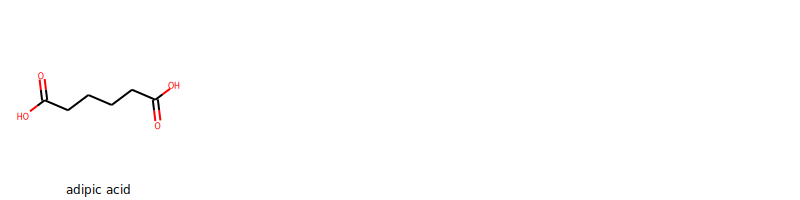

In [6]:
desiredProduct1 = Chem.MolFromSmiles('O=C(O)CCCCC(=O)O')
plotM([desiredProduct1], ["adipic acid"])

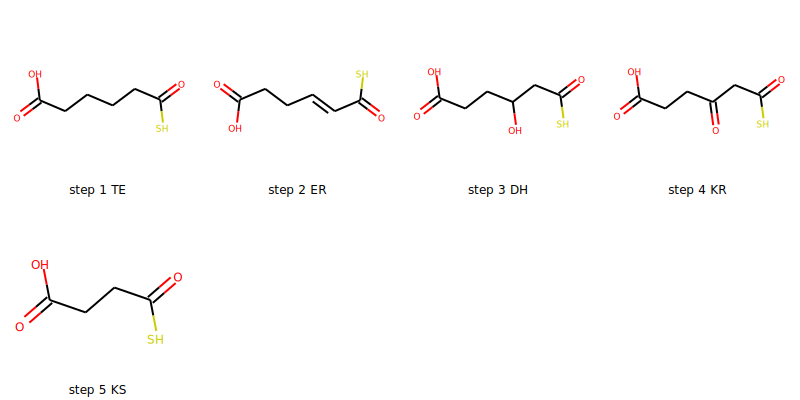

In [7]:
reactions, retroSteps = deconstruct(desiredProduct1)
plotM(retroSteps, reactions)

### Deconstruct 6-deoxyerythronolide B (erythromycin precursor, DEBS product)

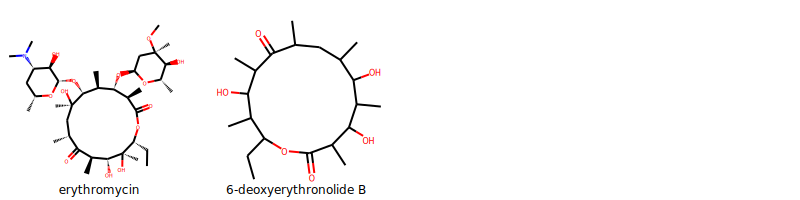

In [8]:
erythromycin = Chem.MolFromSmiles('CC[C@@H]1[C@@]([C@@H]([C@H](C(=O)[C@@H](C[C@@]([C@@H]([C@H]([C@@H]([C@H](C(=O)O1)C)O[C@H]2C[C@@]([C@H]([C@@H](O2)C)O)(C)OC)C)O[C@H]3[C@@H]([C@H](C[C@H](O3)C)N(C)C)O)(C)O)C)C)O)(C)O')
desiredProduct2 = Chem.MolFromSmiles('CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)O)C)O)C)C)C)O)C')
plotM([erythromycin, desiredProduct2], ["erythromycin", "6-deoxyerythronolide B"])

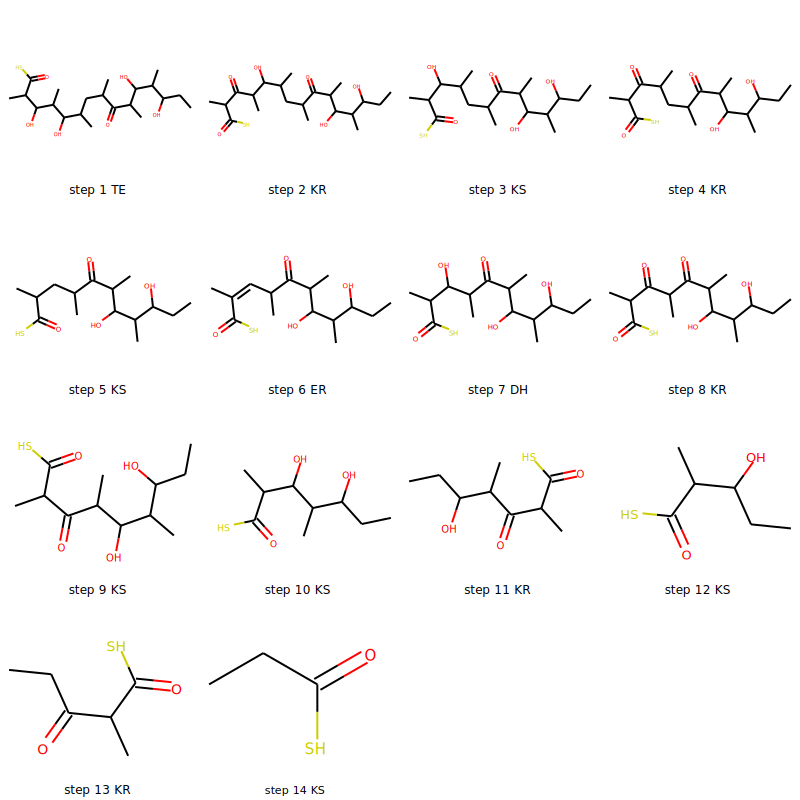

In [9]:
reactions, retroSteps = deconstruct(desiredProduct2)
plotM(retroSteps, reactions)

### Deconstruct narbonolide (pikromycin precursor)

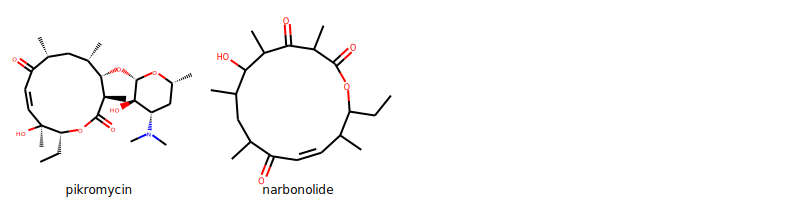

In [10]:
pikromycin = Chem.MolFromSmiles('CC[C@@H]1[C@@](/C=C/C(=O)[C@@H](C[C@@H]([C@@H]([C@H](C(=O)O1)C)O[C@H]2[C@@H]([C@H](C[C@H](O2)C)N(C)C)O)C)C)(C)O')
desiredProduct3 = Chem.MolFromSmiles('CCC1C(C=CC(=O)C(CC(C(C(C(=O)C(C(=O)O1)C)C)O)C)C)C')
plotM([pikromycin, desiredProduct3], ["pikromycin", "narbonolide"])

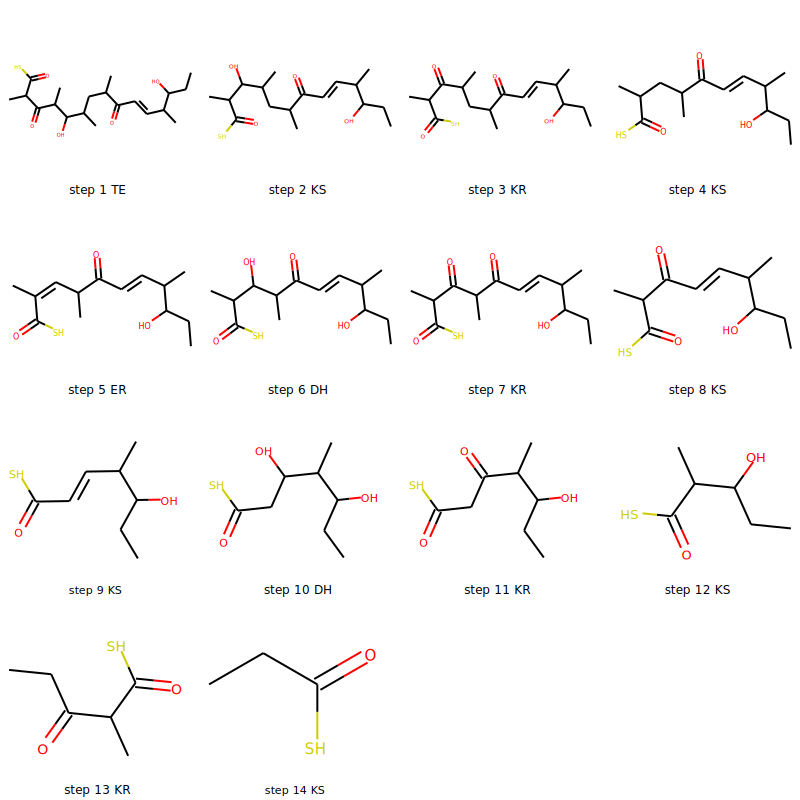

In [11]:
reactions, retroSteps = deconstruct(desiredProduct3)
plotM(retroSteps, reactions)

### Deconstruct nystatin precursor
known biosynthesis reference: http://link.springer.com/article/10.1007%2Fs00253-004-1802-4

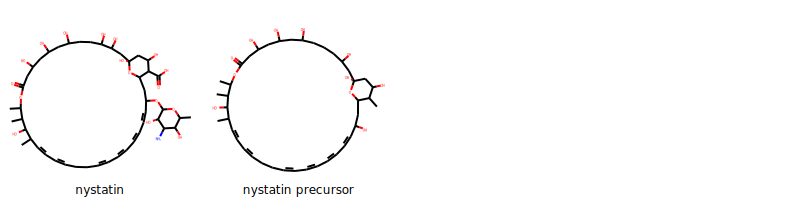

In [12]:
nystatin = Chem.MolFromSmiles('CC1C=CC=CCCC=CC=CC=CC=CC(CC2C(C(CC(O2)(CC(C(CCC(CC(CC(CC(=O)OC(C(C1O)C)C)O)O)O)O)O)O)O)C(=O)O)OC3C(C(C(C(O3)C)O)N)O')
desiredProduct4 = Chem.MolFromSmiles('CC1C=CC=CCCC=CC=CC=CC=CC(CC2C(C(CC(O2)(CC(C(CCC(CC(CC(CC(=O)OC(C(C1O)C)C)O)O)O))O)O)O)C)O')
plotM([nystatin, desiredProduct4], ["nystatin", "nystatin precursor"])

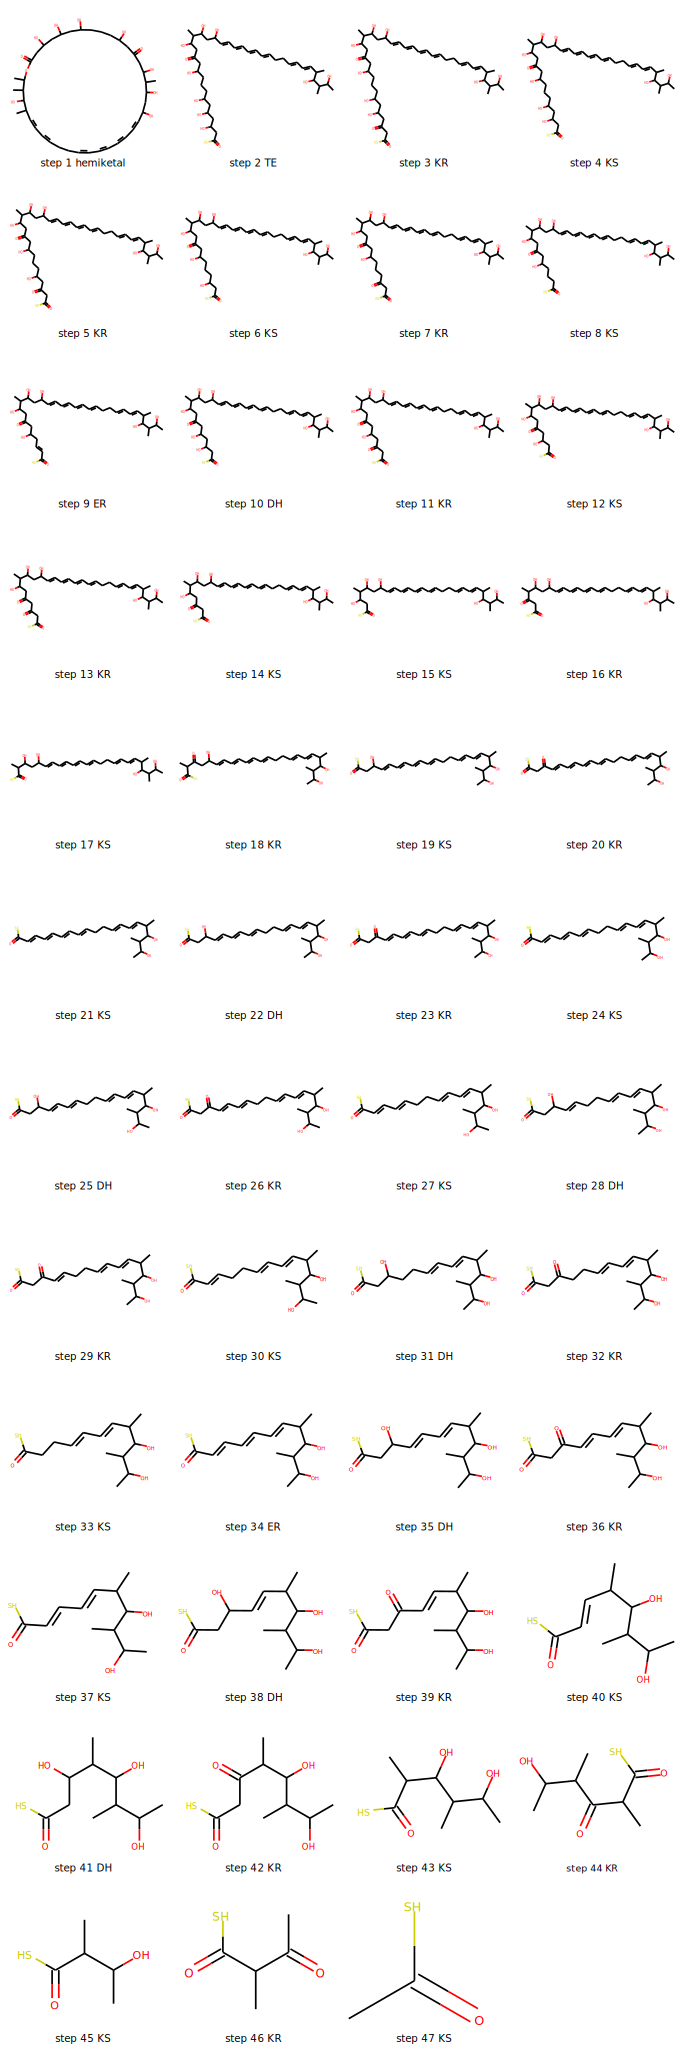

In [13]:
reactions, retroSteps = deconstruct(desiredProduct4)
plotM(retroSteps, reactions)

### Deconstruct borrelidin

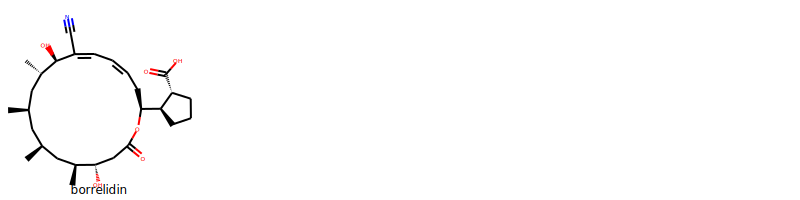

In [14]:
desiredProduct5 = Chem.MolFromSmiles('C[C@H]1C[C@H](C[C@@H]([C@H](/C(=C\C=C\C[C@H](OC(=O)C[C@@H]([C@H](C1)C)O)[C@@H]2CCC[C@H]2C(=O)O)/C#N)O)C)C')
plotM([desiredProduct5], ["borrelidin"])

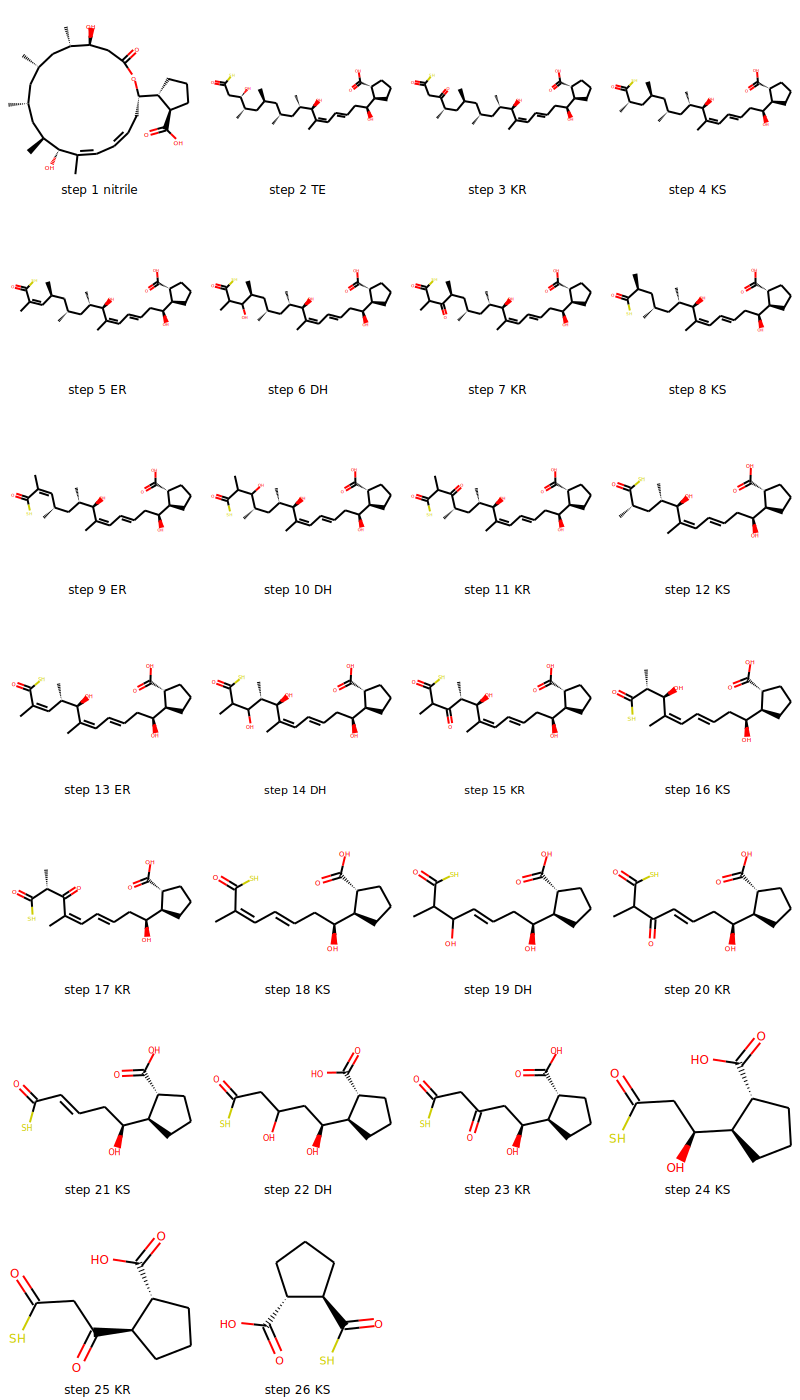

In [15]:
reactions, retroSteps = deconstruct(desiredProduct5)
plotM(retroSteps, reactions)

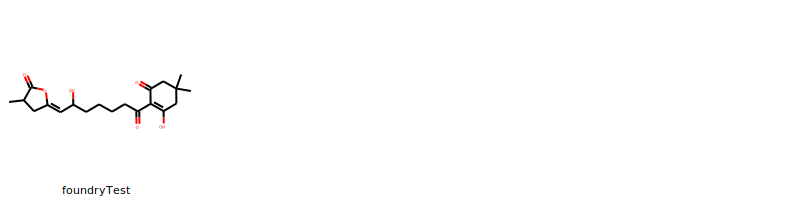

In [68]:
desiredProduct6 = Chem.MolFromSmiles('C1(=C(C(=O)CC(C1)(C)C)C(=O)CCCCC(=O)C1=C(CC(CC1=O)(C)C)O)O')
desiredProduct6 = Chem.MolFromSmiles('C1(=C(C(=O)CC(C1)(C)C)C(=O)CCCCC(O)C=C1(CC(C(=O)O1)C))O')
#desiredProduct6 = Chem.MolFromSmiles('C1(=C(C(=O)CC(C1)(C)C)C(=O)CCCCC(=O)C=C(C(C(C)C(=O)O))O)O')
# desiredProduct6 = Chem.MolFromSmiles('C1(=C(C(=O)CC(C1)(C)C)C(=O)CCCCC(=O)C=C(CC(CC(=O)O))O)O')
plotM([desiredProduct6], ["foundryTest"])

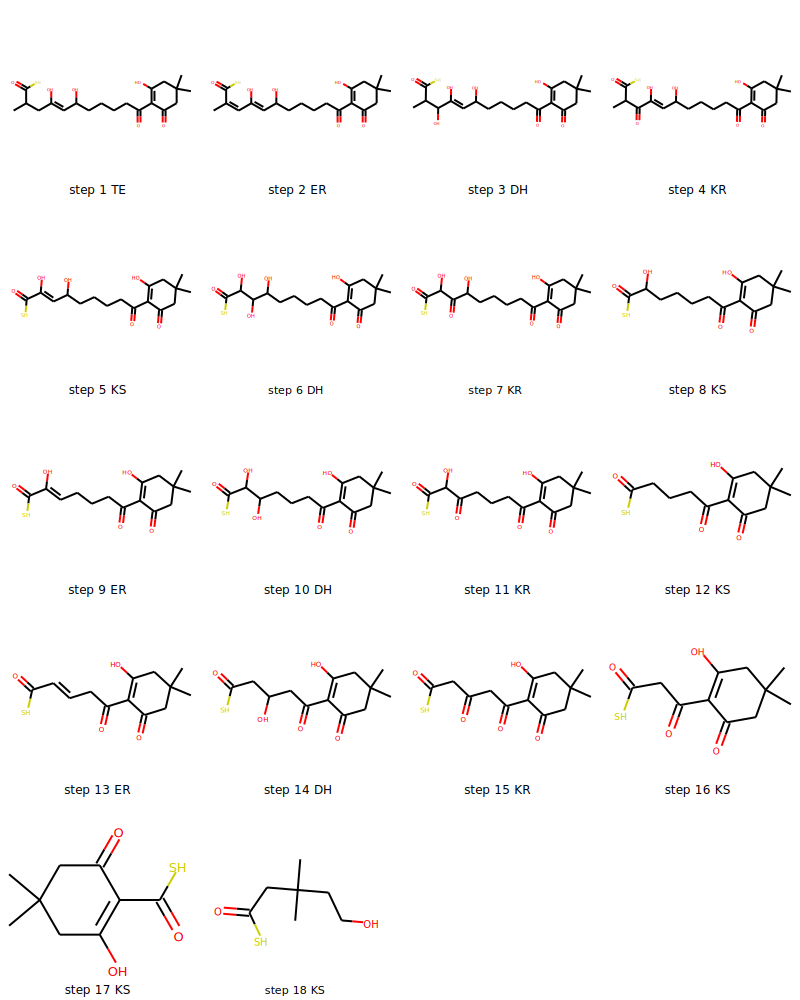

In [69]:
reactions, retroSteps = deconstruct(desiredProduct6)
plotM(retroSteps, reactions)